
-	card: Dummy variable, 1 if application for credit card accepted, 0 if not
-	reports: Number of major derogatory reports
-	age: Age n years plus twelfths of a year
-	income: Yearly income (divided by 10,000)
-	share: Ratio of monthly credit card expenditure to yearly income
-	expenditure: Average monthly credit card expenditure
-	owner: 1 if owns their home, 0 if rent
-	selfempl: 1 if self employed, 0 if not.
-	dependents: 1 + number of dependents
-	months: Months living at current address
-	majorcards: Number of major credit cards held
-	active: Number of active credit accounts

A derogatory mark or remark in your credit report is a negative item, such as a late payment or foreclosure. If a derogatory mark is listed in your credit reports, it can hurt your credit scores and may affect your chances of qualifying for things like credit cards, loans and mortgages.

Столбцы income, expediture и share мультиколлинеарны, так как share - это отношение expediture к income. Пока не будем с этим ничего делать, так как мы собираемся использовать бустинговые модели. Но при feature engineering мы про это вспомним.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
import xgboost as xgb

In [101]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, log_loss

In [4]:
card_data=pd.read_csv("AER_credit_card_data.csv")

In [5]:
card_data

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1314,yes,0,33.58333,4.5660,0.002146,7.333333,yes,no,0,94,1,19
1315,no,5,23.91667,3.1920,0.000376,0.000000,no,no,3,12,1,5
1316,yes,0,40.58333,4.6000,0.026513,101.298300,yes,no,2,1,1,2
1317,yes,0,32.83333,3.7000,0.008999,26.996670,no,yes,0,60,1,7


In [6]:
card_data.isnull().sum(axis=0)

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

In [7]:
card_data.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,0.456406,33.213103,3.365376,0.068732,185.057071,0.993935,55.267627,0.817286,6.996967
std,1.345267,10.142783,1.693902,0.094656,272.218917,1.247745,66.271746,0.386579,6.305812
min,0.000000,0.166667,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.243750,0.002316,4.583333,0.000000,12.000000,1.000000,2.000000
50%,0.000000,31.250000,2.900000,0.038827,101.298300,1.000000,30.000000,1.000000,6.000000
75%,0.000000,39.416670,4.000000,0.093617,249.035800,2.000000,72.000000,1.000000,11.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000


In [8]:
card_data.duplicated().sum()

0

Построим гистограммы, чтобы посмотреть как выглядят данные

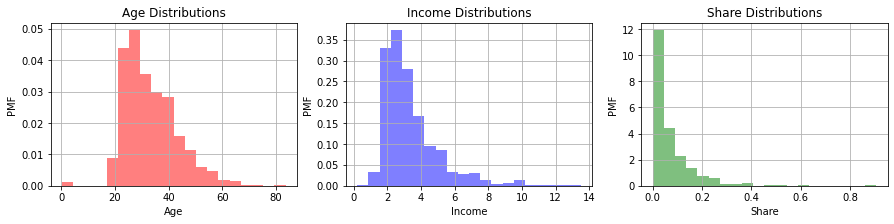

In [9]:
age = card_data["age"]
income = card_data["income"]
share = card_data["share"]
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.xlabel("Age")
plt.ylabel("PMF")
plt.title("Age Distributions")
age.hist(histtype="bar", bins=20, alpha=0.5, color="r", density=1)
plt.subplot(1, 3, 2)
plt.xlabel("Income")
plt.ylabel("PMF")
plt.title("Income Distributions")
income.hist(histtype="bar", bins=20, alpha=0.5, color="b", density=1)
plt.subplot(1, 3, 3)
plt.xlabel("Share")
plt.ylabel("PMF")
plt.title("Share Distributions")
share.hist(histtype="bar", bins=20, alpha=0.5, color="g", density=1)

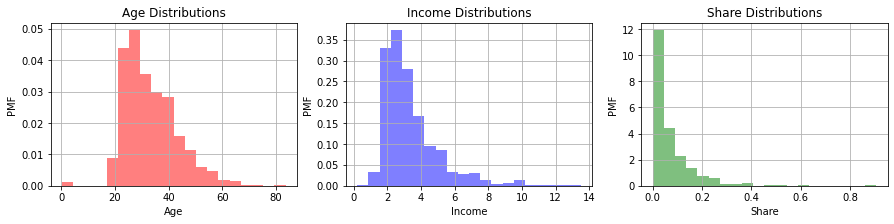

In [10]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.xlabel("Age")
plt.ylabel("PMF")
plt.title("Age Distributions")
card_data["age"].hist(histtype="bar", bins=20, alpha=0.5, color="r", density=1)
plt.subplot(1, 3, 2)
plt.xlabel("Income")
plt.ylabel("PMF")
plt.title("Income Distributions")
card_data["income"].hist(histtype="bar", bins=20, alpha=0.5, color="b", density=1)
plt.subplot(1, 3, 3)
plt.xlabel("Share")
plt.ylabel("PMF")
plt.title("Share Distributions")
card_data["share"].hist(histtype="bar", bins=20, alpha=0.5, color="g", density=1)

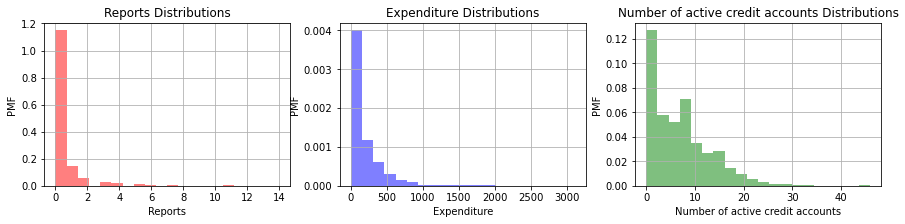

In [11]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.xlabel("Reports")
plt.ylabel("PMF")
plt.title("Reports Distributions")
card_data["reports"].hist(histtype="bar", bins=20, alpha=0.5, color="r", density=1)
plt.subplot(1, 3, 2)
plt.xlabel("Expenditure")
plt.ylabel("PMF")
plt.title("Expenditure Distributions")
card_data["expenditure"].hist(histtype="bar", bins=20, alpha=0.5, color="b", density=1)
plt.subplot(1, 3, 3)
plt.xlabel("Number of active credit accounts")
plt.ylabel("PMF")
plt.title("Number of active credit accounts Distributions")
card_data["active"].hist(histtype="bar", bins=20, alpha=0.5, color="g", density=1)

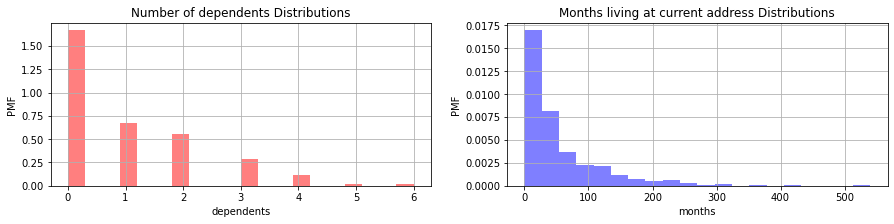

In [18]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.xlabel("dependents")
plt.ylabel("PMF")
plt.title("Number of dependents Distributions")
card_data["dependents"].hist(histtype="bar", bins=20, alpha=0.5, color="r", density=1)
plt.subplot(1, 2, 2)
plt.xlabel("months")
plt.ylabel("PMF")
plt.title("Months living at current address Distributions")
card_data["months"].hist(histtype="bar", bins=20, alpha=0.5, color="b", density=1)

Из графиков мы видим, что есть значения возраста, близкие к нулю.

Данных с близкими к нулю значениями возраста всего 7, поэтому просто удалим их из файла.

In [53]:
card_data=pd.read_csv("AER_credit_card_data_edited.csv")

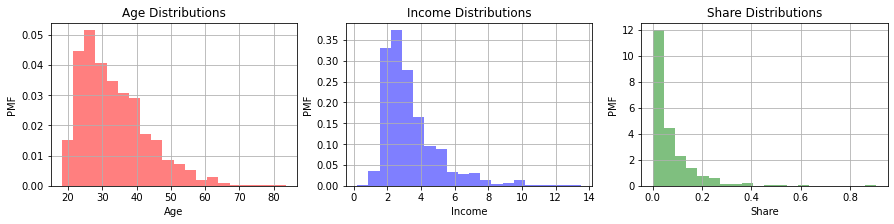

In [14]:
fig = plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
plt.xlabel("Age")
plt.ylabel("PMF")
plt.title("Age Distributions")
card_data["age"].hist(histtype="bar", bins=20, alpha=0.5, color="r", density=1)
plt.subplot(1, 3, 2)
plt.xlabel("Income")
plt.ylabel("PMF")
plt.title("Income Distributions")
card_data["income"].hist(histtype="bar", bins=20, alpha=0.5, color="b", density=1)
plt.subplot(1, 3, 3)
plt.xlabel("Share")
plt.ylabel("PMF")
plt.title("Share Distributions")
card_data["share"].hist(histtype="bar", bins=20, alpha=0.5, color="g", density=1)

In [15]:
card_data.corr()

,reports,age,income,share,expenditure,dependents,months,majorcards,active
reports,1.000000,0.041255,0.010545,-0.158574,-0.136273,0.020255,0.048446,-0.006620,0.208139
age,0.041255,1.000000,0.330573,-0.115791,0.016491,0.219071,0.454619,0.005397,0.185389
income,0.010545,0.330573,1.000000,-0.053676,0.281571,0.317409,0.130519,0.108102,0.181094
share,-0.158574,-0.115791,-0.053676,1.000000,0.838731,-0.084685,-0.054287,0.048620,-0.025525
expenditure,-0.136273,0.016491,0.281571,0.838731,1.000000,0.050465,-0.028117,0.075281,0.053160
dependents,0.020255,0.219071,0.317409,-0.084685,0.050465,1.000000,0.049151,0.007194,0.105744
months,0.048446,0.454619,0.130519,-0.054287,-0.028117,0.049151,1.000000,-0.039545,0.101594
majorcards,-0.006620,0.005397,0.108102,0.048620,0.075281,0.007194,-0.039545,1.000000,0.118194
active,0.208139,0.185389,0.181094,-0.025525,0.053160,0.105744,0.101594,0.118194,1.000000


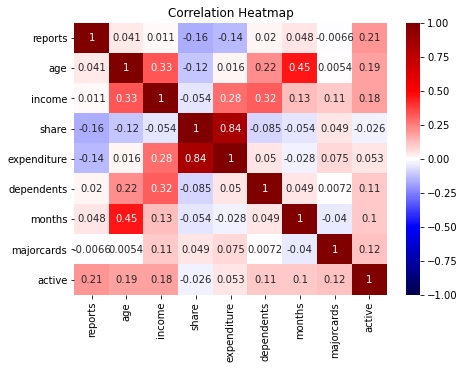

In [16]:
plt.figure(figsize=(7, 5))
plt.title("Correlation Heatmap")
heatmap = sns.heatmap(card_data.corr(), vmin=-1, vmax=1, annot=True, cmap="seismic")

Как и ожидалось, среди данных есть корреляция между собой. Что интересно, share очень сильно коррелирует expediture (0.84), но практически не коррелирует с income. Также зависимость между expediture и income хотя и присутствует, но довольно слабая. То есть линейной зависимости между тем, сколько человек зарабатывает и какую долю дохода он тратит по кредитной карте, не обнаружено.

Вторая по силе зависимость - возраст и количество месяцев, которое человек прожил на последнем месте жительства - кажется достаточно логичной. Также есть линейная зависимость между возрастом и уровнем дохода, но не такая сильная, как ожидалось.

Закодируем категориальные переменные. Так как в каждом столбце только по две категории, то воспользуемся методом LabelEncoding

In [64]:
k = ["card", "owner", "selfemp"]
for i in k:
    le = LabelEncoder()
    n = str(i) + "_n"
    card_data[n] = le.fit_transform(card_data[i])
for i in k:
    del card_data[i]
card_data.head()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,card_n,owner_n,selfemp_n
0,0,37.66667,4.5200,0.033270,124.983300,3,54,1,12,1,1,0
1,0,33.25000,2.4200,0.005217,9.854167,3,34,1,13,1,0,0
2,0,33.66667,4.5000,0.004156,15.000000,4,58,1,5,1,1,0
3,0,30.50000,2.5400,0.065214,137.869200,0,25,1,7,1,0,0
4,0,32.16667,9.7867,0.067051,546.503300,2,64,1,5,1,1,0


In [26]:
card_data.describe()

,reports,age,income,share,expenditure,dependents,months,majorcards,active,card_n,owner_n,selfemp_n
count,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000,1312.000000
mean,0.458079,33.387386,3.367257,0.068636,184.970390,0.993902,55.182927,0.817835,6.999238,0.775152,0.441311,0.069360
std,1.348416,9.884200,1.697377,0.094787,272.714742,1.247408,66.254140,0.386127,6.314718,0.417641,0.496733,0.254162
min,0.000000,18.166670,0.210000,0.000109,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.416670,2.237125,0.002208,4.583333,0.000000,12.000000,1.000000,2.000000,1.000000,0.000000,0.000000
50%,0.000000,31.291665,2.900000,0.038775,101.231650,1.000000,30.000000,1.000000,6.000000,1.000000,0.000000,0.000000
75%,0.000000,39.416670,4.000000,0.093516,248.970800,2.000000,72.000000,1.000000,11.000000,1.000000,1.000000,0.000000
max,14.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,540.000000,1.000000,46.000000,1.000000,1.000000,1.000000


Разделим данные на обучающую, валидационную и тестовую выборки

In [90]:
X = card_data.drop("card_n", axis=1)
y = card_data["card_n"]

x_train_all, x_test, y_train_all, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [91]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_all, y_train_all, test_size=0.3, random_state=1)

In [147]:
x_test

,reports,age,income,share,expenditure,dependents,months,majorcards,active,owner_n,selfemp_n
201,0,33.00000,3.1500,0.057266,150.17670,0,128,0,3,0,1
115,1,37.66667,2.0000,0.060808,101.26250,3,42,1,3,1,0
255,0,35.00000,4.1125,0.029627,101.20080,1,37,1,23,1,0
1040,0,23.91667,2.0000,0.100191,166.90170,0,9,1,0,0,0
195,0,21.91667,2.4000,0.232639,465.19500,1,168,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...
831,1,38.00000,3.2700,0.238693,650.43750,2,7,1,3,0,0
301,0,31.00000,4.0104,0.000299,0.00000,0,42,1,0,0,0
1010,0,42.66667,2.5900,0.031484,67.53584,3,96,1,5,1,1
315,0,27.33333,2.7500,0.067190,153.72670,0,6,1,3,0,0


Поскольку целевая переменная представляет собой 0 и 1, то среднее значение показывает долю каждого из классов. В данных 75,3% класса 'yes', и 24,7% класса 'no'. Таким образом, выборка немного несбалансированная.

In [85]:
y_test.describe()

count    263.000000
mean       0.752852
std        0.432176
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: card_n, dtype: float64

Вопользуемся библиотекой XGBoost для решения задачи классификации.

In [92]:
xgb_model = xgb.XGBClassifier()

xgb_model.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [93]:
 model = xgb_model.fit(x_train, y_train)

[01:48:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [44]:
preds =  model.predict(x_valid)

In [47]:
accuracy_score(y_valid, preds)

0.9746031746031746

In [95]:
preds_test =  model.predict(x_test)

In [96]:
accuracy_score(y_test, preds_test)

0.973384030418251

In [116]:
balanced_accuracy_score(y_test, preds_test)

0.9795648795648796

In [97]:
confusion_matrix(y_test, preds_test)

array([[ 60,   5],
       [  2, 196]], dtype=int64)

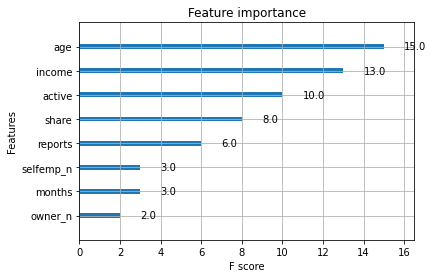

In [64]:
xgb.plot_importance(model)

Как мы видим, точность модели даже с параметрами по умолчанию высокая. Попробуем подобрать более оптимальные параметры.

In [76]:
import hyperopt.hp as hp
from hyperopt import fmin, tpe, STATUS_OK, Trials

In [77]:
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'reg_alpha' : hp.quniform('reg_alpha', 0,30,1),
         'n_estimators': hp.quniform("n_estimators", 1, 11, 1),
          'learning_rate': hp.uniform('learning_rate', 0.05, 0.4),
            'seed': 0}

In [127]:
def objective(space):
    
    model_opt=xgb.XGBClassifier(n_estimators =int(space['n_estimators']),
                                max_depth = int(space['max_depth']),
                                reg_alpha = int(space['reg_alpha']),
                                learning_rate = float(space['learning_rate']),
                                )
    
    evaluation = [( x_train, y_train), ( x_valid, y_valid)]
    
    model_opt.fit(x_train,y_train,
            eval_set=evaluation, eval_metric="logloss",
            early_stopping_rounds=None,verbose=False)
    

    pred = model_opt.predict(x_valid)
    log_loss_pred = log_loss(y_valid,pred)
    print ("SCORE:", log_loss_pred)
    return {'loss': log_loss_pred, 'status': STATUS_OK}

In [128]:
trials = Trials()

In [129]:
%%time
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
  1%|▍                                               | 1/100 [00:00<00:19,  5.16trial/s, best loss: 0.8771752735215419]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
  4%|█▉                                              | 4/100 [00:00<00:14,  6.63trial/s, best loss: 0.8771752735215419]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
  9%|████▎                              

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 12%|█████▋                             

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                  

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 21%|█████████▊                                     | 21/100 [00:01<00:05, 15.61trial/s, best loss: 0.8771752735215419]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use 

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 23%|██████████▊                                    | 23/100 [00:01<00:05, 14.94trial/s, best loss: 0.8771752735215419]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.7675283643313493                                                                                                     
SCORE:                                                                                                                 
0.7675283643313493                                                                                                     
 25%|███████████▊                                   | 25/100 [00:01<00:05, 13.98trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771778119260822                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 29%|█████████████▋                                 | 29/100 [00:01<00:05, 13.33trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 33%|███████████████▌                   

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
                                                                                                                       

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

0.8771752735215419
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 41%|███████████████████▎                           | 41/100 [00:02<00:04, 12.08trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 43%|████████████████████▏                          | 43/100 [00:02<00:04, 12.05trial/s, best loss: 0.7675283643313493]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 45%|█████████████████████▏                         | 45/100 [00:03<00:04, 12.06trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 49%|███████████████████████                        | 49/100 [00:03<00:04, 12.37trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.7675283643313493                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 51%|███████████████████████▉                       | 51/100 [00:03<00:03, 12.40trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 55%|█████████████████████████▊                     | 55/100 [00:03<00:03, 12.41trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 57%|██████████████████████████▊                    | 57/100 [00:04<00:03, 12.62trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 61%|████████████████████████████▋                  | 61/100 [00:04<00:03, 12.08trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 62%|█████████████████████████████▏                 | 62/100 [00:04<00:03, 12.08trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
                                                                                                                       

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



0.9868272595208152
SCORE:                                                                                                                 
0.7675283643313493                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 67%|███████████████████████████████▍               | 67/100 [00:05<00:03,  9.83trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 69%|████████████████████████████████▍              | 69/100 [00:05<00:03, 10.23trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.9868247211162748                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 73%|██████████████████████████████████▎            | 73/100 [00:05<00:02, 10.97trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.9868247211162748                                                                                                     
 75%|███████████████████████████████████▎           | 75/100 [00:05<00:02, 11.16trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 79%|█████████████████████████████████████▏         | 79/100 [00:06<00:01, 10.57trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 81%|██████████████████████████████████████         | 81/100 [00:06<00:01, 10.71trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 83%|███████████████████████████████████████        | 83/100 [00:06<00:01, 10.52trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 85%|███████████████████████████████████████▉       | 85/100 [00:06<00:01, 10.81trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 87%|████████████████████████████████████████▉      | 87/100 [00:07<00:01, 10.75trial/s, best loss: 0.7675283643313493]

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use o

SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 89%|█████████████████████████████████████████▊     | 89/100 [00:07<00:01, 10.92trial/s, best loss: 0.7675283643313493]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 91%|██████████████████████████████████████████▊    | 91/100 [00:07<00:00, 10.42trial/s, best loss: 0.7675283643313493]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 93%|███████████████████████████████████████████▋   | 93/100 [00:07<00:00, 10.54trial/s, best loss: 0.7675283643313493]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 95%|████████████████████████████████████████████▋  | 95/100 [00:07<00:00, 10.65trial/s, best loss: 0.7675283643313493]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
 97%|█████████████████████████████████████████████▌ | 97/100 [00:07<00:00, 10.73trial/s, best loss: 0.7675283643313493]


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
SCORE:                                                                                                                 
0.8771752735215419                                                                                                     
100%|██████████████████████████████████████████████| 100/100 [00:08<00:00, 12.22trial/s, best loss: 0.7675283643313493]
Wall time: 8.2 s


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



In [130]:
print(best_hyperparams)

{'learning_rate': 0.2133631251659376, 'max_depth': 10.0, 'n_estimators': 5.0, 'reg_alpha': 1.0}


In [131]:
xgb_model = xgb.XGBClassifier(n_estimators = 5, max_depth = 10, reg_alpha = 1, learning_rate = 0.2133631251659376)
    
model_xgb = xgb_model.fit(x_train, y_train)

[06:29:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [133]:
preds_valid =  model_xgb.predict(x_valid)
    
balanced_accuracy_score(y_valid, preds_valid)

0.986

In [134]:
preds_test =  model_xgb.predict(x_test)

balanced_accuracy_score(y_test, preds_test)

0.9872571872571874

In [135]:
confusion_matrix(y_test, preds_test)

array([[ 64,   1],
       [  2, 196]], dtype=int64)

Как мы видим, подбор оптимальных параметров увеличил точность модели для меньшего класса.